In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch import Tensor

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import snntorch as snn

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

/home/mikolaj/anaconda3/envs/lic/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using cuda device


In [2]:
np.random.seed(0)

def and_generator(size: int):
  x = Tensor(np.random.choice([0, 1], (size, 2)))
  y = Tensor([1 if i[0] and i[1] else 0 for i in x]).reshape(size, 1)

  return list(zip(x, y))

zipped data = (tensor([1., 0.]), tensor([0.]))


/home/mikolaj/anaconda3/envs/lic/lib/python3.10/site-packages/numpy/lib/arraysetops.py:272: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ar = np.asanyarray(ar)
/home/mikolaj/anaconda3/envs/lic/lib/python3.10/site-packages/numpy/lib/arraysetops.py:272: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)
/home/mikolaj/anaconda3/envs/lic/lib/python3.1

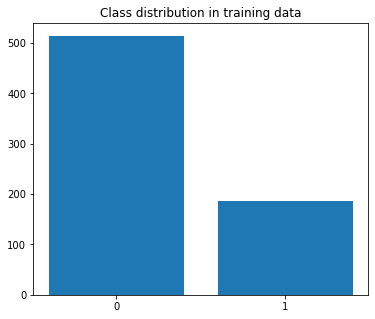

In [3]:
train_data = and_generator(size=700)
train_loader = DataLoader(train_data, 32)
test_loader = DataLoader(and_generator(size=300), 32)

i = 5
print("zipped data =", train_data[i])

y = [i[1] for i in train_data]
plt.figure(figsize=(6, 5))
plt.bar(np.unique(y, return_counts=True)[0], np.unique(y, return_counts=True)[1])
plt.xticks([0, 1])
plt.title("Class distribution in training data")
plt.show()

In [8]:
from snntorch import surrogate

beta = 0.9
spike_grad = surrogate.fast_sigmoid()

# class SNNNetwork(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.one_way = nn.Sequential(
#             nn.Linear(2, 2),
#             snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
#         )

#     def forward(self, x):
#         probs = self.one_way(x)
#         return probs

net = nn.Sequential(
    nn.Linear(2, 2),
    snn.Leaky(beta=beta, spike_grad=spike_grad, init_hidden=True, output=True)
)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# net = SNNNetwork()
net = net.to(device)

Using cuda device


In [9]:
from snntorch import utils

def forward_pass(net, data, num_steps):
  spk_rec = []
  utils.reset(net)

  for step in range(num_steps):
      spk_out, mem_out = net(data)
      spk_rec.append(spk_out)

  return torch.stack(spk_rec)

In [10]:
import snntorch.functional as SF

optimizer = torch.optim.Adam(net.parameters(), lr=2e-3, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [7]:
num_epochs = 10 # run for 1 epoch - each data sample is seen only once
num_steps = 25  # run for 25 time steps

loss_hist = [] # record loss over iterations
acc_hist = [] # record accuracy over iterations

# training loop
for epoch in range(num_epochs):
    for i, (data, targets) in enumerate(iter(train_loader)):
        data = data.to(device)
        targets = targets.squeeze().to(device)

        net.train()
        spk_rec = forward_pass(net, data, num_steps) # forward-pass
        loss_val = loss_fn(spk_rec, targets) # loss calculation
        optimizer.zero_grad() # null gradients
        loss_val.backward() # calculate gradients
        optimizer.step() # update weights
        loss_hist.append(loss_val.item()) # store loss

        # print every 25 iterations
        if i % 25 == 0:
          print(f"Epoch {epoch}, Iteration {i} \nTrain Loss: {loss_val.item():.2f}")

          # check accuracy on a single batch
          acc = SF.accuracy_rate(spk_rec, targets)
          acc_hist.append(acc)
          print(f"Accuracy: {acc * 100:.2f}%\n")
        break

Epoch 0, Iteration 0 
Train Loss: 7.57
Accuracy: 65.62%

Epoch 1, Iteration 0 
Train Loss: 7.57
Accuracy: 65.62%

Epoch 2, Iteration 0 
Train Loss: 7.54
Accuracy: 65.62%

Epoch 3, Iteration 0 
Train Loss: 7.36
Accuracy: 65.62%

Epoch 4, Iteration 0 
Train Loss: 7.36
Accuracy: 65.62%

Epoch 5, Iteration 0 
Train Loss: 7.36
Accuracy: 65.62%

Epoch 6, Iteration 0 
Train Loss: 7.36
Accuracy: 65.62%

Epoch 7, Iteration 0 
Train Loss: 7.36
Accuracy: 65.62%

Epoch 8, Iteration 0 
Train Loss: 7.36
Accuracy: 65.62%

Epoch 9, Iteration 0 
Train Loss: 7.36
Accuracy: 65.62%

